In [1]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
def onehotify(tensor):
    vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'} 
    
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key]) 
    
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,)) 
    
    return onehot

In [3]:
# load "genomics_ood" dataset, split into first 100.000 training and first 1.000 testing samples and shuffle them
train_data, test_data = tfds.load('genomics_ood', split=['train[:100000]', 'test[:1000]'], shuffle_files=True, as_supervised=True)

# the map function calls the lambda function for every single entry of the dataset
# samples are transformed by the formerly defined onehotify function
# targets are transformed by the tensorflow inbuild function tf.one_hot with depth=10, being the number of possible distinct classifications
train_data = train_data.map(lambda sample, target: (onehotify(sample), tf.one_hot(target,depth=10)))
# next samples are formatted to batches, containing 32 samples each
train_data = train_data.batch(32)
# use free computing resources to prepare (up to 10) next training batches
train_data = train_data.prefetch(10)

#we are doing the same thing for the testing data
test_data = test_data.map(lambda sample, target: (onehotify(sample), tf.one_hot(target,depth=10)))
test_data = test_data.batch(32)
test_data = test_data.prefetch(10)


In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [5]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [8]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []
train_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, train_accuracy = test(model, train_data, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_data = train_data.shuffle(buffer_size=128)
    test_data = test_data.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_data:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)
    
    _,train_accuracy = test(model, train_data, cross_entropy_loss)
    train_accuracies.append(train_accuracy)

    #testing
    test_loss, test_accuracy = test(model, test_data, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


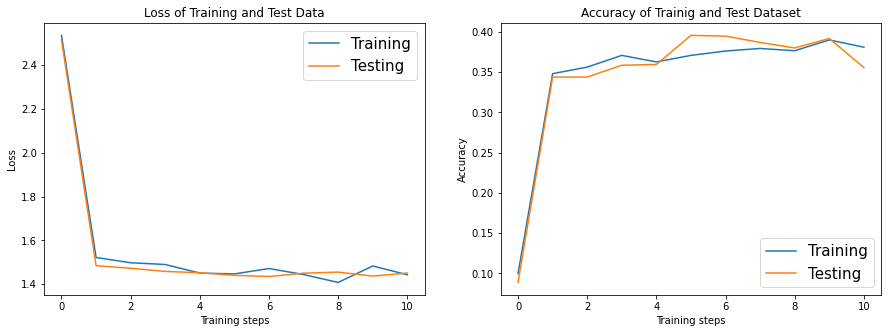

In [10]:
# Visualize accuracy and loss for training and test data

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# One plot training and test loss
axes[0].plot(train_losses, label="Training")
axes[0].plot(test_losses, label="Testing")
axes[0].set(title="Loss of Training and Test Data", xlabel="Training steps", ylabel="Loss")
axes[0].legend(fontsize=15)

# One plot training and test accuracy
axes[1].plot(train_accuracies, label="Training")
axes[1].plot(test_accuracies, label="Testing")
axes[1].set(title="Accuracy of Trainig and Test Dataset", xlabel="Training steps", ylabel="Accuracy")
axes[1].legend(fontsize=15)
plt.show()